# GRAVITATIONAL WAVE BIAS DETECTION
Here we have simulated data of gravitational wave signals produced by black-hole binaries. It is simulated also the detection of the signal by the LIGO experiments, so every event has its Signal to Noise Ratio (SNR). We consider an event 'detectable' if the SNR is greater than 12. So basically we have some events, characterized by some features, labelled 'detectable' or 'not detectable'. We want to build a binary classifier capable of reproducing the selection bias of the detector.

The features we decided to consider are:
1) the total mass;
2) the mass ratio;
3) the location of the sources (given by two numbers);
4) the inclination of the orbit;
5) the distance.

First, we plot a corner plot:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from corner import corner
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from astroML.classification import GMMBayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score

In [3]:
dataset = h5py.File("sample_2e7_design_precessing_higherordermodes_3detectors.h5", 'r')

In [4]:
print(list(dataset.keys()))

['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']


In [5]:
n_sample = 20000000
y = np.array(dataset['det'])[:n_sample]
X = np.transpose(np.array([(dataset['mtot'])[:n_sample], (dataset['q'])[:n_sample], (dataset['ra'])[:n_sample],\
                           (dataset['dec'])[:n_sample], (dataset['iota'])[:n_sample], (dataset['z'])[:n_sample]]))

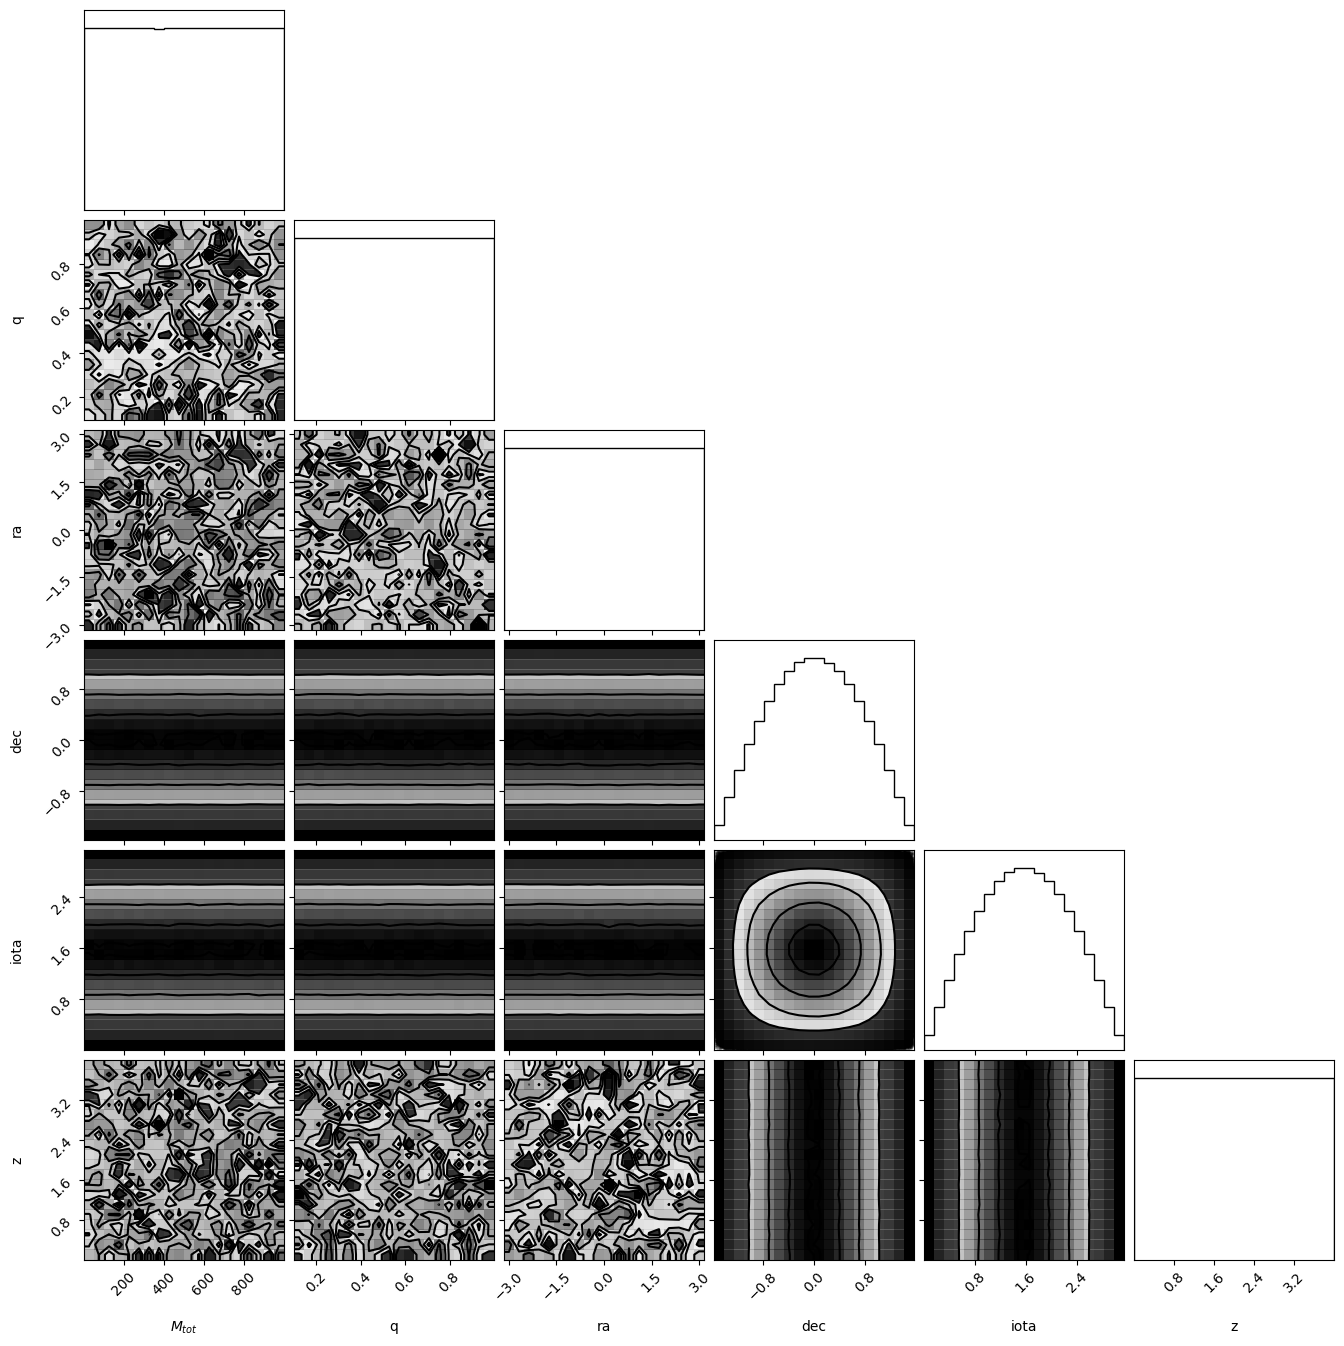

In [5]:
_ = corner(X, labels=[r"$M_{tot}$", r"q", r"ra", r"dec", r"iota", r"z"])

In none of the histograms we can se well separated clusters.


So we proceed in classifying the dataset. We'll try two classifiers: the Random Forest and the Adaptive Boosting.
## Random Forest
We begin cross-validating the depth of the decision trees to get the model with the best trade between accuracy and complexity:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
depth_max = 20
acc_train = np.zeros(depth_max)
acc_test = np.zeros(depth_max)
for i in range(1, depth_max+1):
    clf = RandomForestClassifier(n_estimators=10, max_depth=i, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    acc_train[i-1] = accuracy_score(y_train, y_train_pred)
    acc_test[i-1] = accuracy_score(y_test, y_test_pred)

Text(0, 0.5, 'Accuracy')

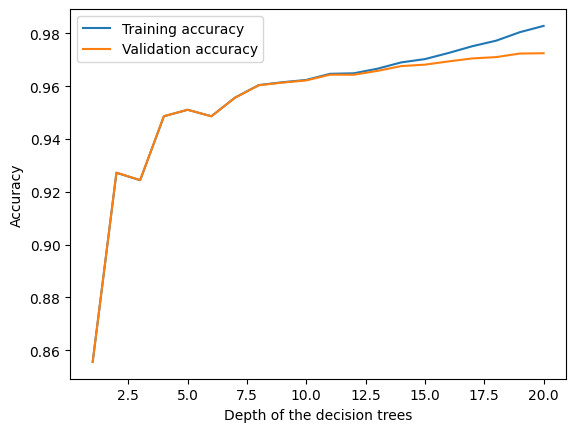

In [19]:
plt.plot(range(1, depth_max+1), acc_train, label = "Training accuracy")
plt.plot(range(1, depth_max+1), acc_test, label = "Validation accuracy")
plt.legend()
plt.xlabel("Depth of the decision trees")
plt.ylabel("Accuracy")

We can choose the best model, given by the depth where the plateau of the validation accuracy begins:

In [20]:
depth_best_RF = 16
print("Best accuracy: {}; obtained with a depth of {}".format(acc_test[depth_best_RF], depth_best_RF + 1))

Best accuracy: 0.9705135; obtained with a depth of 17


## Adaptive Boosting
We now do the same things we have just done but for the Adaptive Boosting:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
depth_max = 15
acc_train = np.zeros(depth_max)
acc_test = np.zeros(depth_max)
for i in range(1, depth_max+1):
    clf = GradientBoostingClassifier(n_estimators=10, max_depth=i)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    acc_train[i-1] = accuracy_score(y_train, y_train_pred)
    acc_test[i-1] = accuracy_score(y_test, y_test_pred)

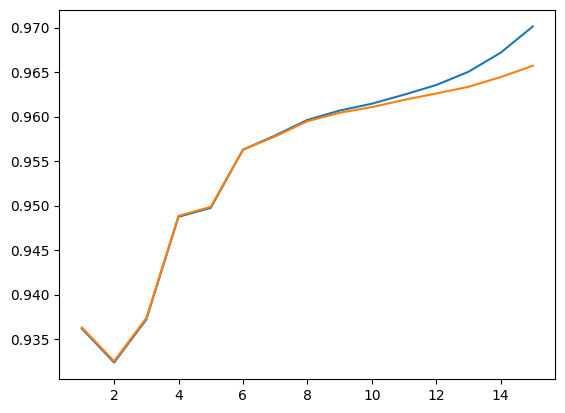

In [10]:
plt.plot(range(1, depth_max+1), acc_train)
plt.plot(range(1, depth_max+1), acc_test)

Again we choose the best model, given by the depth where the plateau of the validation accuracy begins:

In [17]:
depth_best_B = 11
print("Best accuracy: {}; obtained with a depth of {}".format(acc_test[depth_best_B], depth_best_B + 1))

Best accuracy: 0.9625886666666666; obtained with a depth of 12


## Comparison
In terms of accuracy, the two classifiers are very similar, at least with this set of features. We can compare them further using the ROC curve:

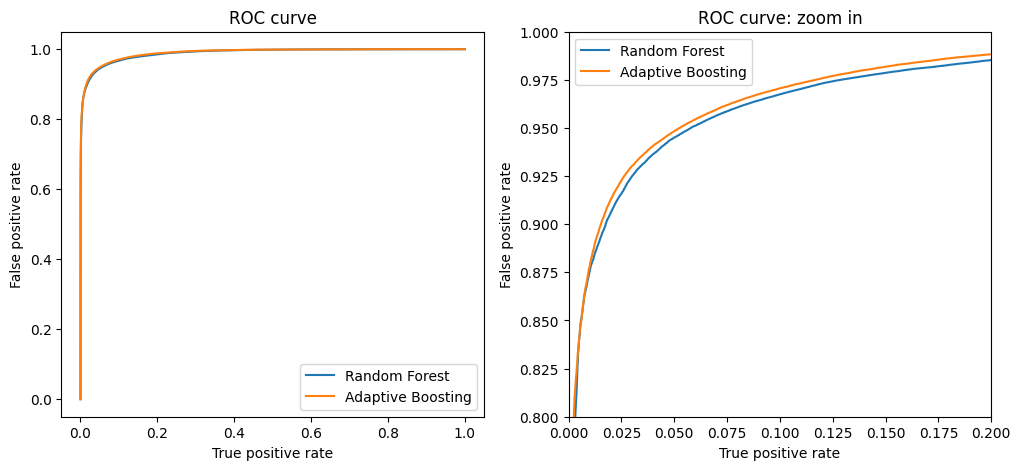

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)
plt.figure(figsize=(12, 5))
clf = RandomForestClassifier(n_estimators=10, max_depth=depth_best_RF, n_jobs=-1)
clf.fit(X_train, y_train)
y_test_prob = clf.predict_proba(X_test)[:, 0]
fps, tps, _ = roc_curve(y_test, y_test_prob)
plt.subplot(1, 2, 1)
plt.plot(tps, fps, label = "Random Forest")
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title("ROC curve")
plt.subplot(1, 2, 2)
plt.plot(tps, fps, label = "Random Forest")
plt.xlim(0.0, 0.2)
plt.ylim(0.8, 1.0)
plt.xlabel("True positive rate")
plt.ylabel("False positive rate")
plt.title("ROC curve: zoom in")

clf = GradientBoostingClassifier(n_estimators=10, max_depth=depth_best_B)
clf.fit(X_train, y_train)
y_test_prob = clf.predict_proba(X_test)[:, 0]
fps, tps, _ = roc_curve(y_test, y_test_prob)
plt.subplot(1, 2, 1)
plt.plot(tps, fps, label = "Adaptive Boosting")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(tps, fps, label = "Adaptive Boosting")
plt.xlim(0.0, 0.2)
plt.ylim(0.8, 1.0)
plt.legend()

The two curves are very similar, but since the Random Forest is much faster, I would choose this classifier.